# Document Clustering and Topic Modeling

## Overview

Based on moive reviews we collected, in the project we will use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures with the text analysis and topic modeling.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
# read the movie name
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

In [43]:
len(synopses)

100

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [10]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 153 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [11]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
tokenization_and_stemming("she looked at her father's arm.")

[u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [12]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [13]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['angel']

angeles


# Part 3: TF-IDF

This method could help us to identify the bags of words which could be used in the model, which reflect the importance of words,and reduce the importance of frequently appeared words.

In [32]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [34]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [35]:
tf_selected_words = tfidf_model.get_feature_names()
tf_selected_words[1]

u'abandon'

In [37]:
len(tf_selected_words)

538

# (Optional) Calculate Document Similarity

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[ 1.          0.1996283   0.23342595 ...,  0.3581728   0.3277855
   0.17714484]
 [ 0.1996283   1.          0.26626879 ...,  0.26910321  0.22856581
   0.10870124]
 [ 0.23342595  0.26626879  1.         ...,  0.27738654  0.24669308
   0.12805055]
 ..., 
 [ 0.3581728   0.26910321  0.27738654 ...,  1.          0.55040973
   0.08151334]
 [ 0.3277855   0.22856581  0.24669308 ...,  0.55040973  1.          0.13005234]
 [ 0.17714484  0.10870124  0.12805055 ...,  0.08151334  0.13005234  1.        ]]


# Part 4: K-means clustering

In [45]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [46]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [22]:
frame.head(10)

,rank,title,cluster
1,0,The Godfather,1
1,1,The Shawshank Redemption,1
1,2,Schindler's List,1
2,3,Raging Bull,2
1,4,Casablanca,1
3,5,One Flew Over the Cuckoo's Nest,3
1,6,Gone with the Wind,1
4,7,Citizen Kane,4
1,8,The Wizard of Oz,1
4,9,Titanic,4


In [51]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
2,38
1,25
4,19
0,11
3,7


In [52]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 100) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,47.636364
1,42.960000
2,52.342105
3,59.428571
4,49.842105


In [54]:
km.cluster_centers_.argsort()

array([[354, 180, 266, ...,  80, 511,  35],
       [388, 132,  87, ..., 309, 452, 271],
       [ 35,  80, 250, ..., 320,  83, 359],
       [168,  82,  81, ..., 349, 302, 213],
       [441, 389, 367, ..., 327, 194, 192]])

In [55]:
km.cluster_centers_.argsort()[:, ::-1]

array([[ 35, 511,  80, ..., 266, 180, 354],
       [271, 452, 309, ...,  87, 132, 388],
       [359,  83, 320, ..., 250,  80,  35],
       [213, 302, 349, ...,  81,  82, 168],
       [192, 194, 327, ..., 367, 389, 441]])

In [25]:
print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ",",
    print
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies)
    print

<Document clustering result by K-means>
Cluster 0 words: george, marries, family, woman, friend, john,
Cluster 0 titles (6 movies): 
It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Tootsie

Cluster 1 words: family, war, home, sister, house, new,
Cluster 1 titles (24 movies): 
The Godfather, The Shawshank Redemption, Schindler's List, Casablanca, Gone with the Wind, The Wizard of Oz, The Godfather: Part II, Forrest Gump, The Sound of Music, E.T. the Extra-Terrestrial, A Streetcar Named Desire, The Best Years of Our Lives, Ben-Hur, Doctor Zhivago, The Pianist, Goodfellas, Midnight Cowboy, Out of Africa, Terms of Endearment, Giant, The Grapes of Wrath, Network, Wuthering Heights, Yankee Doodle Dandy

Cluster 2 words: car, police, father, killing, say, asks,
Cluster 2 titles (39 movies): 
Raging Bull, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some L

## 4.2. Plot K-means Result

In [57]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

In [61]:
cluster_names

{0: 'george, marries, family, woman, friend, john',
 1: 'family, war, home, sister, house, new',
 2: 'car, police, father, killing, say, asks',
 3: 'soldiers, killing, army, commanded, general, orders',
 4: 'ship, water, singing, board, attempting, appear'}

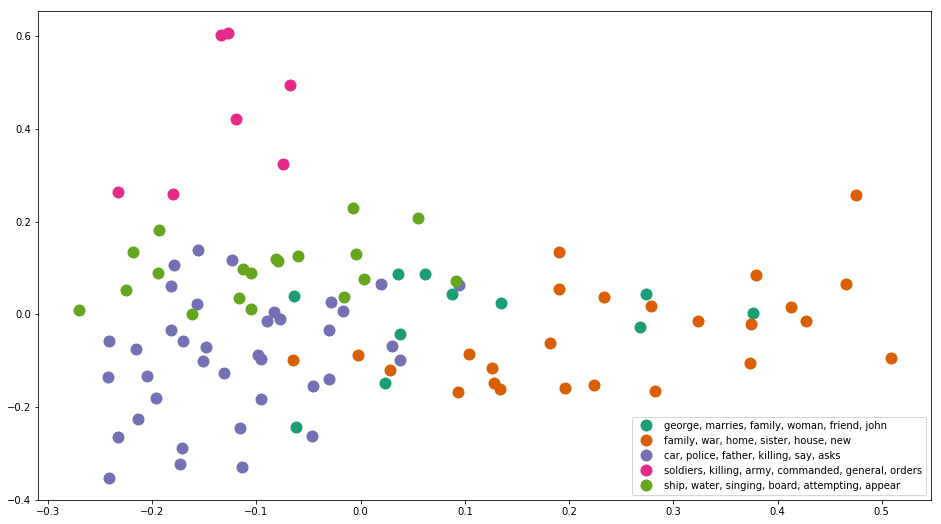

In [58]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [28]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [66]:
#Now we use synopses to build a 100*551 matrix (terms)
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1  # arrange the count in the list based on the order in the tf_selected_words
    current_doc_stats = np.asarray(current_doc_stats)  # count the number of appearance in docs
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)




In [74]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [82]:
topic_keywords_list

[[u'george', u'war', u'soldiers', u'army', u'captain', u'commanded'],
 [u'car', u'away', u'police', u'meet', u'helping', u'apartment'],
 [u'father', u'family', u'new', u'end', u'life', u'years'],
 [u"n't", u'days', u'friend', u'comes', u'say', u'house'],
 [u'killing', u'death', u'men', u'use', u'john', u'shooting']]

In [ ]:
# LDA model require the input should be list of integer, so based on the idf matrix, I used the multiplier to convert that into integer

In [151]:
my_matrix=tfidf_matrix.toarray()
my_matrix_t=[[0 for i in range(my_matrix.shape[1])] for j in range(my_matrix.shape[0])]
for i in range(my_matrix.shape[0]):
    for j in range(my_matrix.shape[1]):
        my_matrix_t[i][j]=int(my_matrix[i][j]*100)

In [152]:
type(my_matrix_t[0][0])

int

In [153]:
from scipy.sparse import csr_matrix

In [154]:
tfidf_matrix_t = csr_matrix(my_matrix_t)
model.fit(tfidf_matrix_t)

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 88408
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -702591
INFO:lda:<10> log likelihood: -619569
INFO:lda:<20> log likelihood: -597571
INFO:lda:<30> log likelihood: -591203
INFO:lda:<40> log likelihood: -586975
INFO:lda:<50> log likelihood: -584666
INFO:lda:<60> log likelihood: -583894
INFO:lda:<70> log likelihood: -583083
INFO:lda:<80> log likelihood: -581911
INFO:lda:<90> log likelihood: -580543
INFO:lda:<100> log likelihood: -579487
INFO:lda:<110> log likelihood: -579047
INFO:lda:<120> log likelihood: -578722
INFO:lda:<130> log likelihood: -578627
INFO:lda:<140> log likelihood: -577950
INFO:lda:<150> log likelihood: -578048
INFO:lda:<160> log likelihood: -577927
INFO:lda:<170> log likelihood: -577140
INFO:lda:<180> log likelihood: -577658
INFO:lda:<190> log likelihood: -576753
INFO:lda:<200> log likelihood: -577070
INFO:lda:<210> log likelihood: -576692
INFO:lda:<220> log likelihood: -5765

<lda.lda.LDA instance at 0x1a14aef0e0>

In [155]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [156]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()  # get the index of max value in array
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: police, car, george, killing, apartment, murder
Cluster 0 titles (37 movies): 
The Godfather, The Shawshank Redemption, Casablanca, Psycho, Vertigo, On the Waterfront, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, It's a Wonderful Life, Raiders of the Lost Ark, A Streetcar Named Desire, Ben-Hur, Doctor Zhivago, Jaws, The Good, the Bad and the Ugly, The Treasure of the Sierra Madre, The Apartment, The Pianist, Goodfellas, The Deer Hunter, The French Connection, It Happened One Night, A Place in the Sun, Rain Man, Fargo, American Graffiti, Pulp Fiction, Stagecoach, The Maltese Falcon, Double Indemnity, Rebel Without a Cause, Rear Window, The Third Man, North by Northwest

Cluster 1 words: captain, prison, water, ship, camping, guard
Cluster 1 titles (11 movies): 
Schindler's List, Titanic, The Sound of Music, Star Wars, 2001: A Space Odyssey, The Bridge on the River Kwai, The Grapes of 

##### Another way to do it is to directly count the number of appearance of the words

In [75]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -484683
INFO:lda:<10> log likelihood: -428330
INFO:lda:<20> log likelihood: -412489
INFO:lda:<30> log likelihood: -406790
INFO:lda:<40> log likelihood: -403019
INFO:lda:<50> log likelihood: -400070
INFO:lda:<60> log likelihood: -398296
INFO:lda:<70> log likelihood: -397266
INFO:lda:<80> log likelihood: -395732
INFO:lda:<90> log likelihood: -395476
INFO:lda:<100> log likelihood: -394666
INFO:lda:<110> log likelihood: -394617
INFO:lda:<120> log likelihood: -393980
INFO:lda:<130> log likelihood: -393121
INFO:lda:<140> log likelihood: -392773
INFO:lda:<150> log likelihood: -392559
INFO:lda:<160> log likelihood: -392274
INFO:lda:<170> log likelihood: -391875
INFO:lda:<180> log likelihood: -392254
INFO:lda:<190> log likelihood: -391966
INFO:lda:<200> log likelihood: -391777
INFO:lda:<210> log likelihood: -391467
INFO:lda:<220> log likelihood: -3910

In [90]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()  # get the index of max value in array
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: george, war, soldiers, army, captain, commanded
Cluster 0 titles (10 movies): 
Schindler's List, Lawrence of Arabia, It's a Wonderful Life, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Patton, Dances with Wolves, Stagecoach, Mutiny on the Bounty

Cluster 1 words: car, away, police, meet, helping, apartment
Cluster 1 titles (13 movies): 
Titanic, The Silence of the Lambs, The Apartment, The Pianist, The French Connection, It Happened One Night, Fargo, The Graduate, The Maltese Falcon, Double Indemnity, Rebel Without a Cause, Rear Window, North by Northwest

Cluster 2 words: father, family, new, end, life, years
Cluster 2 titles (28 movies): 
The Godfather, Casablanca, Citizen Kane, The Godfather: Part II, Sunset Blvd., Forrest Gump, The Sound of Music, Singin' in the Rain, Amadeus, A Streetcar Named Desire, The Best Years of Our Lives, Doctor Zhiva

# Appendix: K-means

As the documentation states Scikit-learn's make_blobs makes a number of isotropic Gaussian blobs. It can be viewed as a helper function, which saves you a little code. Nice if you have to demonstrate or test some clustering algorithm, so to avoid to much boilerplate code.

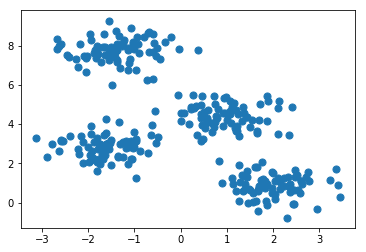

In [91]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

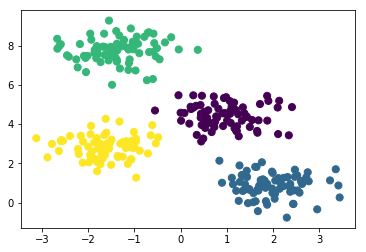

In [93]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);